# Humor Detection Project

In [ ]:
import numpy as np
import pandas as pd
import nltk
import string

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

## Reading in pickle files and CSVs

In [ ]:
oneliners = pd.read_pickle('humorous_oneliners.pickle') # supposed to be funny
proverbs = pd.read_pickle('proverbs.pickle') # not funny
reuters_headlines = pd.read_pickle('reuters_headlines.pickle') # not funny
wiki_sentences = pd.read_pickle('wiki_sentences.pickle') # not funny

NameError: name 'pd' is not defined

In [ ]:
shortjokes = pd.read_csv('shortjokes.csv') # supposed to be funny
shortjokes_df = shortjokes.drop(['ID'], axis = 1).rename(columns = {"Joke": "Line"}).sample(frac = 0.02, replace = False)
shortjokes_df['Funny'] = 1

NameError: name 'shortjoke_df' is not defined

In [ ]:
print("oneliners length: ", len(oneliners))
print("shortjokes length: ", len(shortjokes_df))
print("proverbs length: ", len(proverbs))
print("reuters length: ", len(reuters_headlines))
print("wiki length: ", len(wiki_sentences))

oneliners length:  5251
shortjokes length:  4633
proverbs length:  1019
reuters length:  5243
wiki length:  5251


In [ ]:
oneliner_df = pd.DataFrame(data = {'Line': oneliners, 'Funny': 1})
proverbs_df = pd.DataFrame(data = {'Line': proverbs, 'Funny': 0})
reuters_headlines_df = pd.DataFrame(data = {'Line': reuters_headlines, 'Funny': 0})
wiki_sentences_df = pd.DataFrame(data = {'Line': wiki_sentences, 'Funny': 0})

# data is a 2 column dataframe with one column containing the joke and the other denoting whether it is funny(1) or not(0)
data = pd.concat([oneliner_df, proverbs_df, reuters_headlines_df, wiki_sentences_df, shortjokes_df])

# we only want to randomly sample half of our dataframe
data = data.sample(frac = 0.25, replace = False)
og_data = data.copy()

,Line,Funny
1724,Mowgli begins to run and Baloo pushes Shere Kh...,0
892,Police are after the 'knitting needle nutter' ...,1
2126,"My gambling addiction cost me my marriage! Or,...",1
2658,Study shows researchers waste a lot of time fi...,1
657,This makes it acceptable to many Arians and Un...,0
...,...,...
930,German minister warns countries not to push re...,0
386,Why did the golfer wear two pairs of trousers?...,1
1778,"Asia stocks subdued before U.S. jobs data, dol...",0
3746,What do you call a sheep with no legs?\nA cloud,1


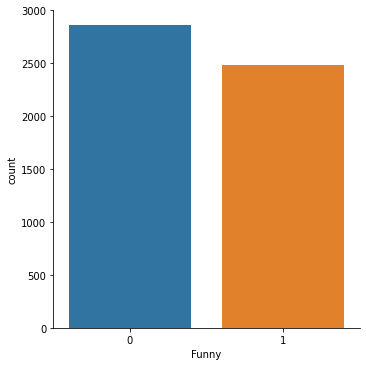

In [ ]:
sns.catplot(x='Funny', kind = 'count', data = data)

## Data Cleaning

In [ ]:
# Check for null values.
print(data.isnull().any(axis = 0))

Line     False
Funny    False
dtype: bool


In [ ]:
# Tokenize

''' Splits elements in the Line series into lists of words. '''
def Tokenize(string):
    lst = string.split()
    return lst

data["Line"] = data["Line"].apply(Tokenize)

In [ ]:
# lower case

''' Takes in a tokenized list and makes all words lower case. '''
def lower_case(lst):
    lowered = []
    for i in lst:
        lowered.append(i.lower())
    return lowered
data["Line"] = data["Line"].apply(lower_case)

In [ ]:
# remove punctuation and symbols

''' Removed punctuation from tokenized list. '''
def remove_punc(lst):
    removed = []
    for i in lst:
        stripped = i.strip(string.punctuation)
        if stripped is not '':
            removed.append(stripped)
    return removed
data["Line"] = data["Line"].apply(remove_punc)

In [ ]:
# remove numbers

''' Removed numbers from tokenized list. '''
def remove_numbers(lst):
    numbers = "0123456789"
    no_numbers = []
    for i in lst:
        i = ''.join([j for j in i if not j.isdigit()])
        no_numbers.append(i)
    return no_numbers
data["Line"] = data["Line"].apply(remove_numbers)


In [ ]:
# remove stopwords
from nltk.corpus import stopwords

nltk.download('stopwords')
english_stopwords = stopwords.words("english")

''' Removes stopwords from tokenized list. '''
def remove_stopwords(lst):
    return [i for i in lst if not i in english_stopwords]
data["Line"] = data["Line"].apply(remove_stopwords)



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

''' Lemmatizes words in a tokenized list'''
def lemmatize(lst):
    lemmatized_words = []
    for i in lst:
        lemmatized_words.append(wordnet_lemmatizer.lemmatize(i, pos = "v"))
    return lemmatized_words
data["Line"] = data["Line"].apply(lemmatize)


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Machine Learning

#### TF-IDF

In [ ]:
data['Line'] = data['Line'].apply(lambda x: ''.join(i+' ' for i in x))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_x_tfidf, test_x_tfidf, train_y_tfidf, test_y_tfidf = train_test_split(data.Line, data.Funny, test_size = 0.2, random_state = 2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# without ngram 
tfidf = TfidfVectorizer() 
train_1_tfidf = tfidf.fit_transform(train_x_tfidf)
test_1_tfidf = tfidf.transform(test_x_tfidf)

# with ngram 
tfidf_ngram = TfidfVectorizer(ngram_range = (1, 2))  
train_1_ngram = tfidf_ngram.fit_transform(train_x_tfidf)
test_1_ngram = tfidf_ngram.transform(test_x_tfidf)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
# without ngram 
train_arr_tfidf = train_1_tfidf.toarray()
test_arr_tfidf = test_1_tfidf.toarray()

# with ngram
train_arr_ngram = train_1_ngram.toarray()
test_arr_ngram = test_1_ngram.toarray()

#### Logistic Regression Model

In [ ]:
# Logistic Regression w/out ngram
from sklearn.linear_model import LogisticRegression
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(train_arr_tfidf, train_y_tfidf)
logreg_tfidf_predicted = logreg_tfidf.predict(test_arr_tfidf)

from sklearn.metrics import f1_score, accuracy_score
logreg_score_tfidf = f1_score(test_y_tfidf, logreg_tfidf_predicted)
print("F1 score: ", logreg_score_tfidf)
logreg_accuracy_tfidf = accuracy_score(test_y_tfidf, logreg_tfidf_predicted) * 100
print("Accuracy: ", logreg_accuracy_tfidf)

print("------------------------------------------")

# Logistic Regression w/ngram
logreg_ngram = LogisticRegression()
logreg_ngram.fit(train_arr_ngram, train_y_tfidf)
logreg_ngram_predicted = logreg_ngram.predict(test_arr_ngram)

logreg_score_ngram = f1_score(test_y_tfidf, logreg_ngram_predicted)
print("w/ngram F1 score: ", logreg_score_ngram)
logreg_accuracy_ngram = accuracy_score(test_y_tfidf, logreg_ngram_predicted) * 100
print("w/ngram Accuracy: ", logreg_accuracy_ngram)

F1 score:  0.8824742268041238
Accuracy:  89.34579439252337
------------------------------------------
w/ngram F1 score:  0.8816326530612244
w/ngram Accuracy:  89.1588785046729


#### Naive Bayes Model

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb_tfidf = MultinomialNB()
nb_tfidf.fit(train_arr_tfidf, train_y_tfidf)
nb_tfidf_predicted = nb_tfidf.predict(test_arr_tfidf)

from sklearn.metrics import f1_score, accuracy_score
nb_score_tfidf = f1_score(test_y_tfidf, nb_tfidf_predicted)
print("F1 score: ", nb_score_tfidf)
nb_accuracy_tfidf = accuracy_score(test_y_tfidf, nb_tfidf_predicted) * 100
print("Accuracy: ", nb_accuracy_tfidf)

print("------------------------------------------")

# Naive Bayes w/ngram
nb_ngram = MultinomialNB()
nb_ngram.fit(train_arr_ngram, train_y_tfidf)
nb_ngram_predicted = nb_ngram.predict(test_arr_ngram)

nb_score_ngram = f1_score(test_y_tfidf, nb_ngram_predicted)
print("w/ngram F1 score: ", nb_score_ngram)
nb_accuracy_ngram = accuracy_score(test_y_tfidf, nb_ngram_predicted) * 100
print("w/ngram Accuracy: ", nb_accuracy_ngram)

F1 score:  0.9026548672566372
Accuracy:  90.74766355140187
------------------------------------------
w/ngram F1 score:  0.9009009009009009
w/ngram Accuracy:  90.74766355140187


#### Support Vector Machine

In [ ]:
# SVM
from sklearn.svm import SVC, LinearSVC
svc_tfidf = LinearSVC()
svc_tfidf.fit(train_arr_tfidf, train_y_tfidf)
svc_tfidf_predicted = svc_tfidf.predict(test_arr_tfidf)

from sklearn.metrics import f1_score, accuracy_score
svc_score_tfidf = f1_score(test_y_tfidf, svc_tfidf_predicted)
print("F1 score: ", svc_score_tfidf)
svc_accuracy_tfidf = accuracy_score(test_y_tfidf, svc_tfidf_predicted) * 100
print("Accuracy: ", svc_accuracy_tfidf)

print("------------------------------------------")

# SVM w/ngram
svc_ngram = LinearSVC()
svc_ngram.fit(train_arr_ngram, train_y_tfidf)
svc_ngram_predicted = svc_ngram.predict(test_arr_ngram)

svc_score_ngram = f1_score(test_y_tfidf, svc_ngram_predicted)
print("w/ngram F1 score: ", svc_score_ngram)
svc_accuracy_ngram = accuracy_score(test_y_tfidf, svc_ngram_predicted) * 100
print("w/ngram Accuracy: ", svc_accuracy_ngram)

F1 score:  0.8866599799398195
Accuracy:  89.43925233644859
------------------------------------------
w/ngram F1 score:  0.9014925373134328
w/ngram Accuracy:  90.74766355140187


In [ ]:
results = pd.DataFrame({
    'Model': ['Logsitic Regression', 'Naive Bayes', 'SVC'],
    'TF-IDF': [logreg_accuracy_tfidf, nb_accuracy_tfidf, svc_accuracy_tfidf],
    'w/ N-Grams': [logreg_accuracy_ngram, nb_accuracy_ngram, svc_accuracy_ngram],
})
results = results.sort_values(by = 'Model', ascending = False)
results

,Model,TF-IDF,w/ N-Grams
2,SVC,89.439252,90.747664
1,Naive Bayes,90.747664,90.747664
0,Logsitic Regression,89.345794,89.158879
